# Работу выполнили 
Студенты группы 4230М А.Н. Секунов, Д.А. Фомин.

# Цель работы

Дан многомерный размеченный набор данных. Необходимо выполнить предиктивный анализ данных на основе регрессионных моделей в соответствии со следующей последовательностью этапов.

# Ход работы

1. Загрузить необходимые пакеты и библиотеки.
2. Загрузить данные из указанного источника.
3. Выполнить разведочный анализ данных в соответствии с этапами описанными в файле Этапы проекта машинного обучения в примерах 1/2.pdf:

    a. Ознакомление с данными с помощью методов описательной статистики;
    
    b. Выполнить визуализацию данных одномерную для понимания распределения данных и многомерную для выяснения зависимостей между признаками;
    
    c. При необходимости выполнить очистку данных одним из методов.
    
    d. Проанализировать корреляционную зависимость между признаками;
    
    e. Поэкспериментировать с комбинациями атрибутов. При необходимости добавить новые атрибуты в набор данных.
    
    f. Выполнить отбор существенных признаков. Сформировать набор данных из существенных признаков.
    
    g. При необходимости преобразовать текстовые или категориальные признаки одним из методов.
    
    h. Выполнить преобразование данных для обоих наборов (исходного и сформированного) одним из методов по варианту.
    
4. В имеющихся двух наборах данных (исходном и их существенных признаков) выделить обучающую и тестовую выборки данных.
5. Сравнить линейную (по варианту) и полиномиальную регрессионные модели на обучающих выборках для обоих наборов данных. Для оценки качества моделей использовать метрики: корень из среднеквадратичной ошибки, R2.
6. Для лучшей модели на лучшем наборе данных выполнить Grid поиск лучшего гиперпараметра регрессионной модели на обучающей выборке. Построить графики результатов поиска. Определить значение лучшего гиперпараметра.
7. Для лучшей модели на лучшем наборе данных выполнить Grid поиск лучшего гиперпараметра регрессионной модели на тестовом выборке. Построить графики результатов поиска. Скорректировать значение лучшего гиперпараметра модели.
8. Сделать выводы по проведенному анализу.

# Исходные данные

Вариант 2.

Набор данных цен на недвижимость. Построить регрессионную модель для целевого признака «Y house price of unit area» (цена объекта недвижимости) от
остальных входных признаков.

- Пункт 3.h – Стандартизация
- Пункт 4 – эластичная сеть (регуляризованная линейная регрессия)

# Выполнение работы

## Загрузка используемых пакетов библиотек

In [1]:
import tarfile
import urllib.request
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from pickle import dump
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

%matplotlib inline
pd.options.mode.chained_assignment = None

## Загрузка исходных данных

In [2]:
HOUSING_URL = 'https://github.com/Demetrey/DMaP/blob/master/LR1/datasets/LR1_datasets.tar.gz?raw=true'
HOUSING_PATH = os.path.join('datasets', 'housing')

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'LR1_datasets.tar.gz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
HOUSING_FILENAME = os.path.join(HOUSING_PATH, 'V2.csv')
housing = pd.read_csv(HOUSING_FILENAME)

## Разведочный анализ данных

### (a) Ознакомление с данными с помощью методов описательной статистики

#### Просмотр необработанных данных

In [6]:
housing.head()

,Unnamed: 0,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2,3,2013.583,NaN,561.98450,5,24.98746,121.54391,47.3
3,3,4,2013.500,NaN,561.98450,5,24.98746,121.54391,54.8
4,4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


Описание столбцов:
- Unnamed: 0 - Индекс записи
- No = номер записи по порядку (с единицы)
- X1 transaction date - дата транзакции;
- X2 house age - возраст дома;
- X3 distance to the nearest MRT station - расстояние до ближайшей станции метро;
- X4 number of convenience stores - количество магазинов шаговой доступности;
- X5 latitude - широта;
- X6 longitude - долгота;
- Y house price of unit area - цена объекта недвижимости.

Для упращения дальнейших действий, было принято решение убрать первые 2 столбца (индекс записи и номер по порядку).

In [7]:
housing.drop(['Unnamed: 0', 'No'], axis=1, inplace=True)  # inplace - изменение текущего DF
housing.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,NaN,561.98450,5,24.98746,121.54391,47.3
3,2013.500,NaN,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


#### Получение более подробной информации (размерности и типов данных)

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   X1 transaction date                     414 non-null    float64
 1   X2 house age                            205 non-null    float64
 2   X3 distance to the nearest MRT station  414 non-null    float64
 3   X4 number of convenience stores         414 non-null    int64  
 4   X5 latitude                             414 non-null    float64
 5   X6 longitude                            414 non-null    float64
 6   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 22.8 KB


Все атрибуты являются числовыми. В столбце X2 содержится 205 непустых значений из 414.

#### Сводка по числовым атрибутам (вывод описательной статистики **?**)

In [9]:
housing.describe()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,205.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,18.206829,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.747338,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.000000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.200000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,30.300000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


Пояснение:

- count - количество не пустых значений;
- mean - среднее (матожидание);
- std - стандартное отклонение;
- min - минимальное значение;
- 25% - 25-ый процентиль (25% выборки меньше данного значения);
- 50% - медиана (50% выборки меньше данного значения);
- 75% - 75-ый процентиль (75% выборки меньше данного значения);
- max - максимальное значение.

### (b) Визуализация данных

#### Одномерные графики

##### Гистограммы

Гистограмма отображает количество образцов, имеющих заданный диапазон значений. Заданное количество бинов: 10.

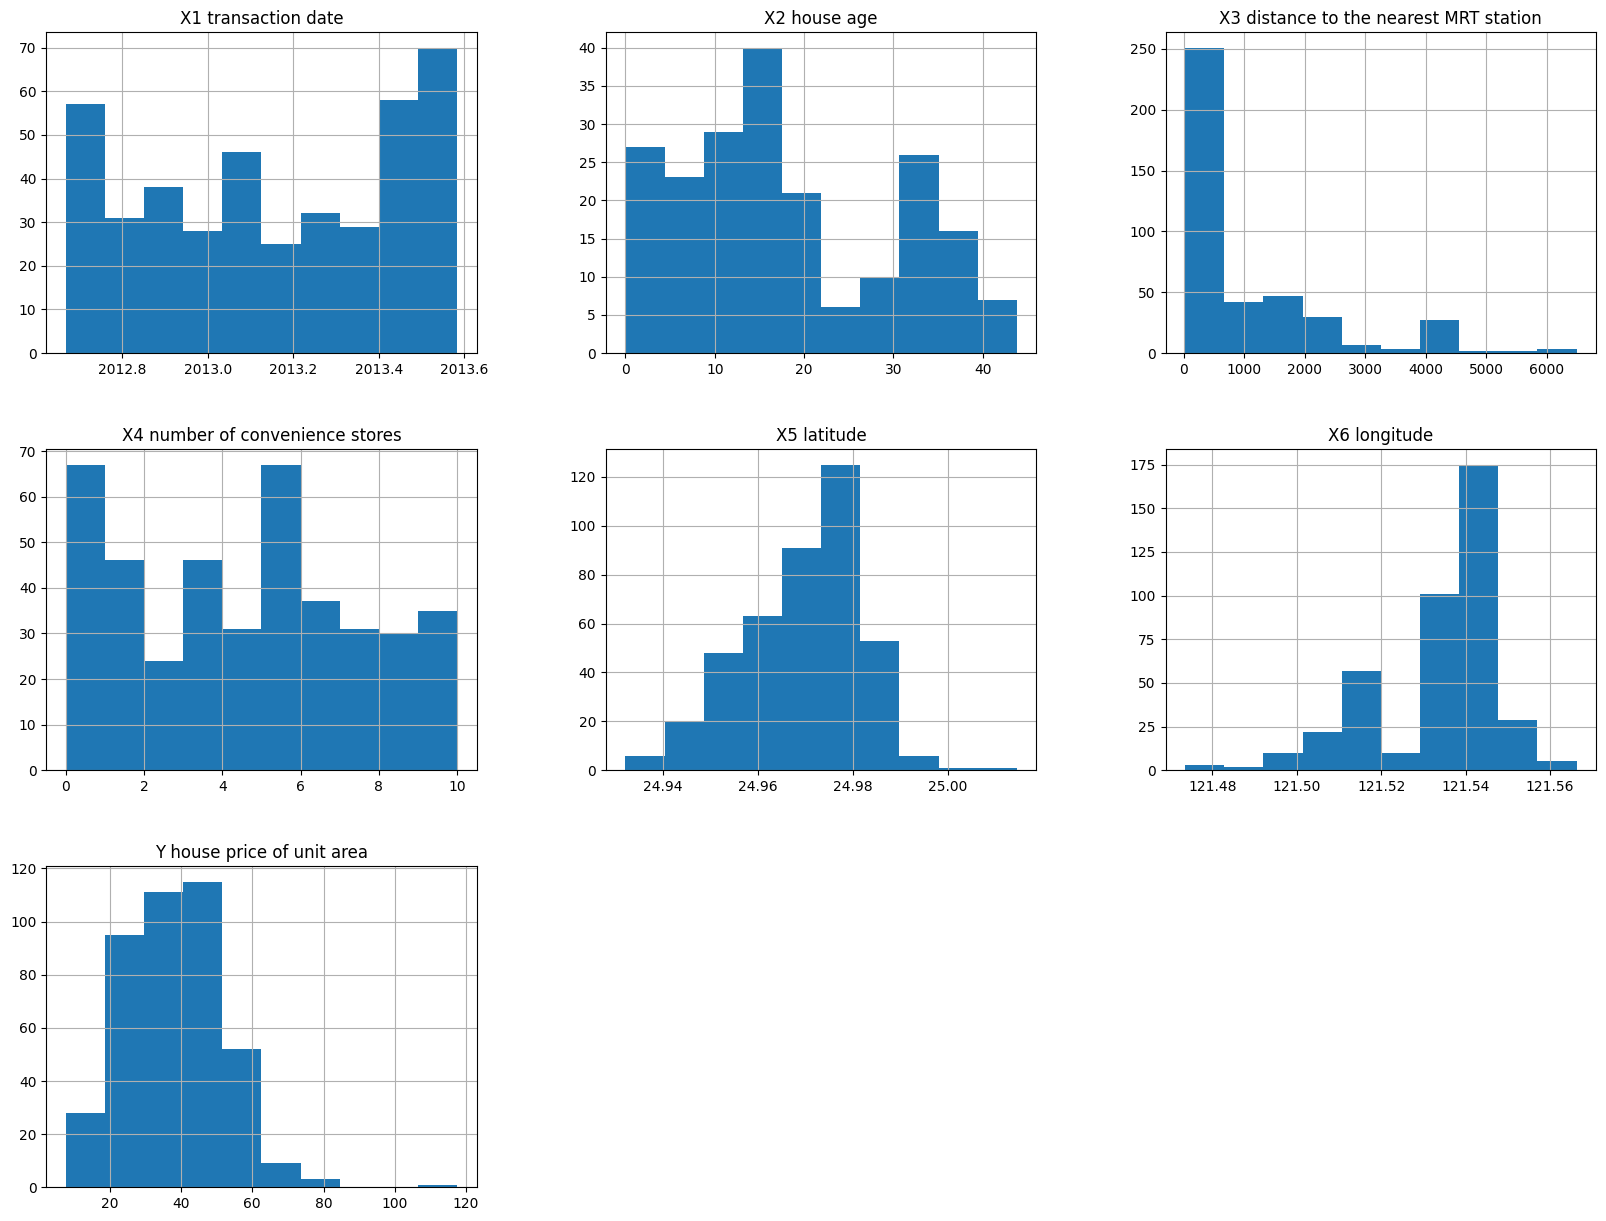

In [10]:
trash = housing.hist(bins=10, figsize=(20, 15))

##### Графики плотности распределения

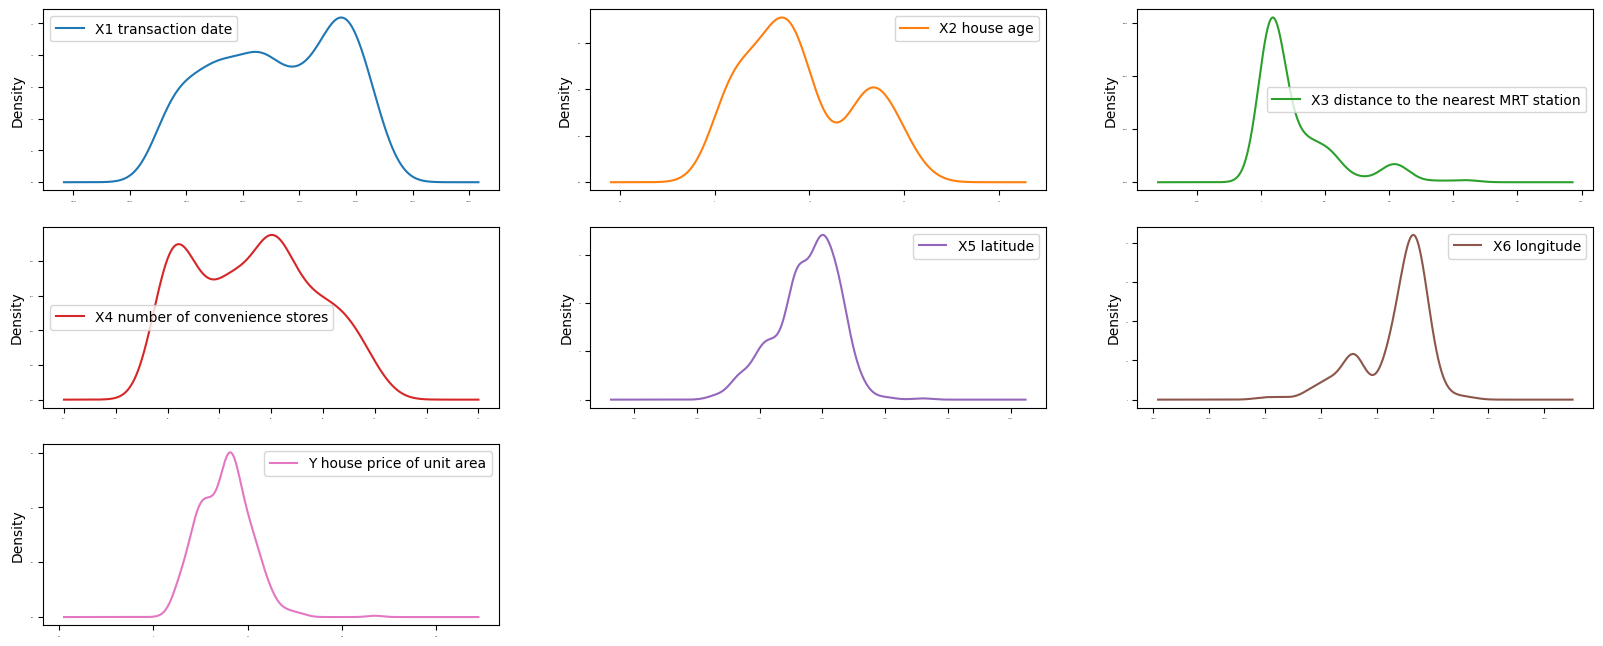

In [11]:
trash = housing.plot(kind='density', subplots=True, layout=(3, 3), sharex=False, legend=True, fontsize=1, figsize=(20,8))

#### Многомерные графики

##### График корреляционной матрицы

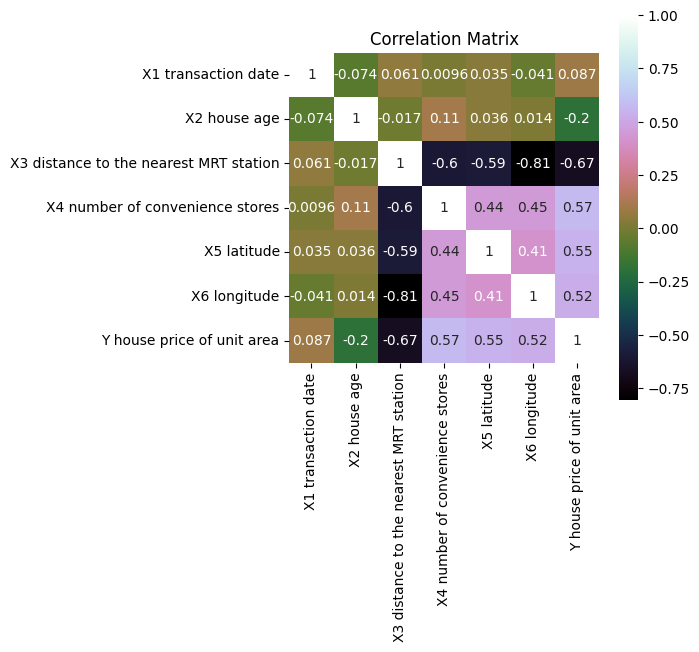

In [12]:
correlation = housing.corr()
plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix')
trash = sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

Исходя из полученных значений, можно сделать вывод, что коэффициенты корреляции столбцов X1 и X2 с Y малы по сравнению с другими 

##### Диаграмма рассеивания

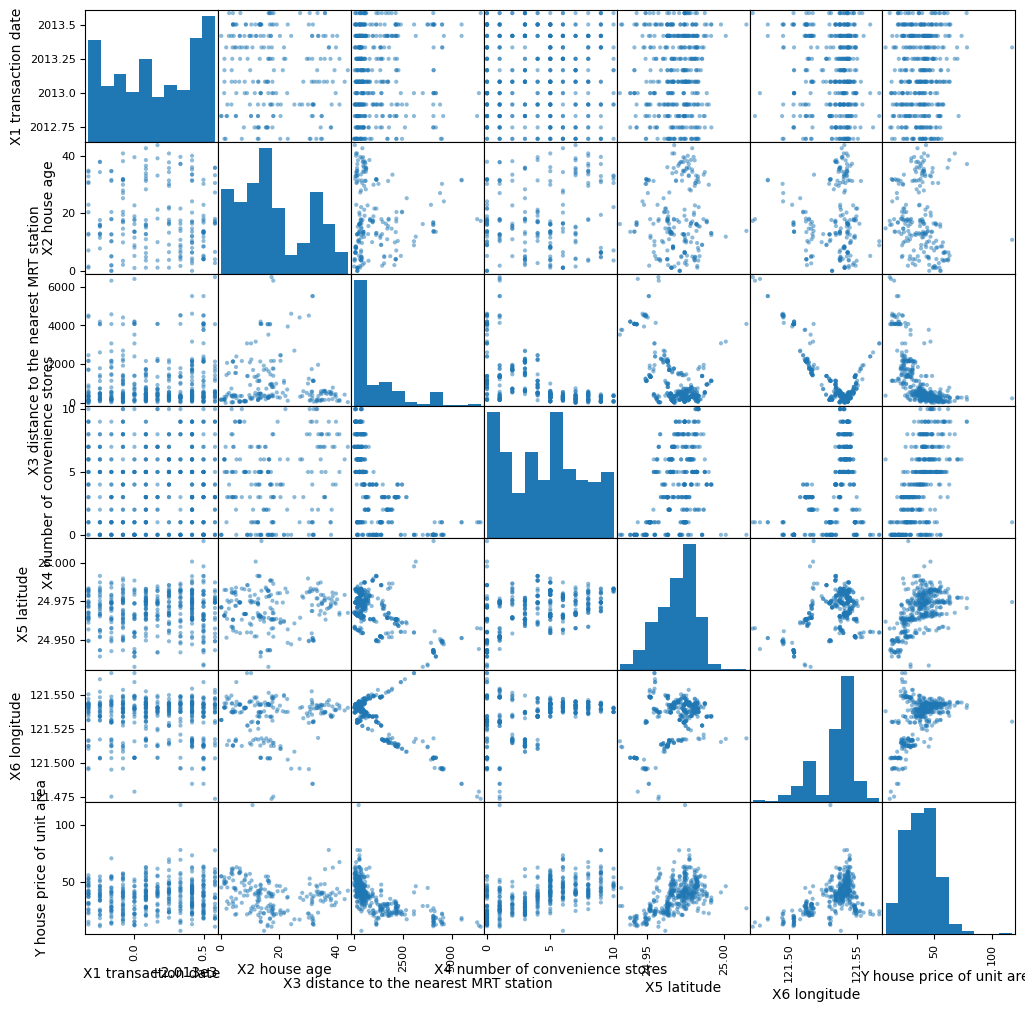

In [13]:
trash = scatter_matrix(housing, figsize=(12, 12))

Из диаграмм рассеивания видно, что X1, X4 - имеют линейную корреляцию с Y, X3, X2, X5, X6 - похожи на полиномиальную.

#### Визуализация географических данных

Рассмотрим зависимость цен на недвижимость от географического положения.

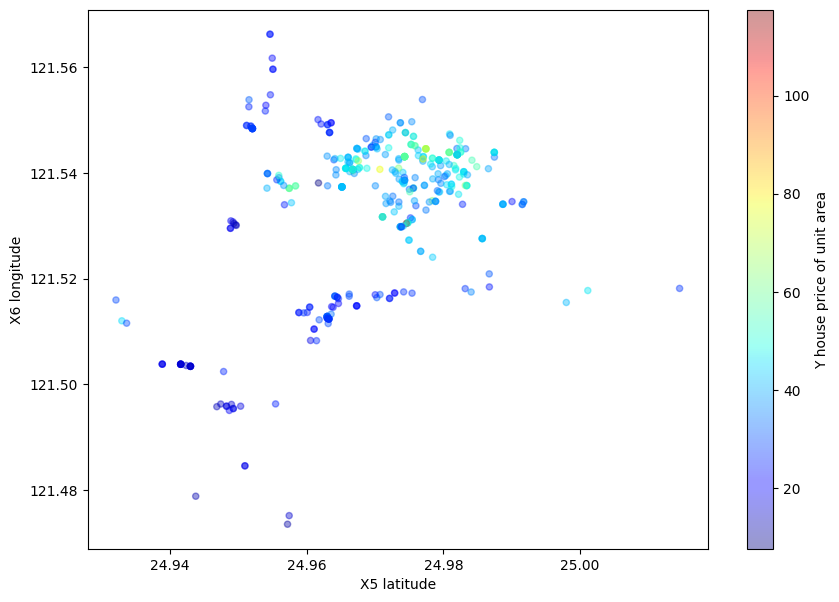

In [14]:
trash = housing.plot(kind='scatter', x=housing.columns[4], y=housing.columns[5],
                     alpha=0.4, figsize=(10, 7), c=housing.columns[6],
                     cmap=plt.get_cmap('jet'), colorbar=True)

Цвет отображает цену на объект недвижимости.

Однозначные выводы из резултатов сделать сложно. С одной стороны, присутствует поределенная область, где цены на недвижимость явно выше, чем по всей остальной территории, однако, в непосредственной близости к этой области встречается дешевая недвижимость. Также дорогая недвижимость встречаются в отдалении от данной области. Таким образом, выдедить нахождение в конкретной области как правило высокой цены на недвижимость нельзя.

### (с) Выполним очистку данных

Проведем очистку данных несколькими методами:
- удалим соответствующие записи;
- установим недостающие значения на медиану;
- установим недостающие значения на среднее;
- установим недостающие значения на 0.

In [15]:
lst_housing_X2_Y = [housing.iloc[:, [1, 6]] for _ in range(4)]
lst_housing_X2_Y[0].dropna(inplace=True)  # Удаление строк
name_x2 = housing.columns[1]
# заполнение медианой
median = lst_housing_X2_Y[1][name_x2].median()
lst_housing_X2_Y[1][name_x2].fillna(median, inplace=True)
# заполнение средним
avg = lst_housing_X2_Y[2][name_x2].mean()
lst_housing_X2_Y[2][name_x2].fillna(avg, inplace=True)
# заполнение нулем
lst_housing_X2_Y[3][name_x2].fillna(0, inplace=True)

Выведем коээфициенты корреляции для каждого случая:

In [16]:
names = ['del_rows', 'median', 'mean', 'zeros']
for name, tab in zip(names, lst_housing_X2_Y):
    x2_y_corr = tab.corr()
    print(f'corr(X2_{name}, Y) = {x2_y_corr.iloc[0, 1]:.3f}')

corr(X2_del_rows, Y) = -0.195
corr(X2_median, Y) = -0.144
corr(X2_mean, Y) = -0.144
corr(X2_zeros, Y) = -0.098


По результатам построения корреляционных матриц, можно сделать вывод, что замена значений и удаление соответствующих записей не дает улучшений значения коэффициента корреляции по сравнению с исходными значениями корреляционной матрицы. По сравнению с другими параметрами (X3-X6), X2 имеет малый коэффициент корреляции, им можно пренеберечь.

In [17]:
housing.drop([housing.columns[1]], axis=1, inplace=True)
housing

,X1 transaction date,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,84.87882,10,24.98298,121.54024,37.9
1,2012.917,306.59470,9,24.98034,121.53951,42.2
2,2013.583,561.98450,5,24.98746,121.54391,47.3
3,2013.500,561.98450,5,24.98746,121.54391,54.8
4,2012.833,390.56840,5,24.97937,121.54245,43.1
...,...,...,...,...,...,...
409,2013.000,4082.01500,0,24.94155,121.50381,15.4
410,2012.667,90.45606,9,24.97433,121.54310,50.0
411,2013.250,390.96960,7,24.97923,121.53986,40.6
412,2013.000,104.81010,5,24.96674,121.54067,52.5


### (d) Анализ корелляционной зависимости между признаками

<Axes: title={'center': 'Correlation Matrix'}>

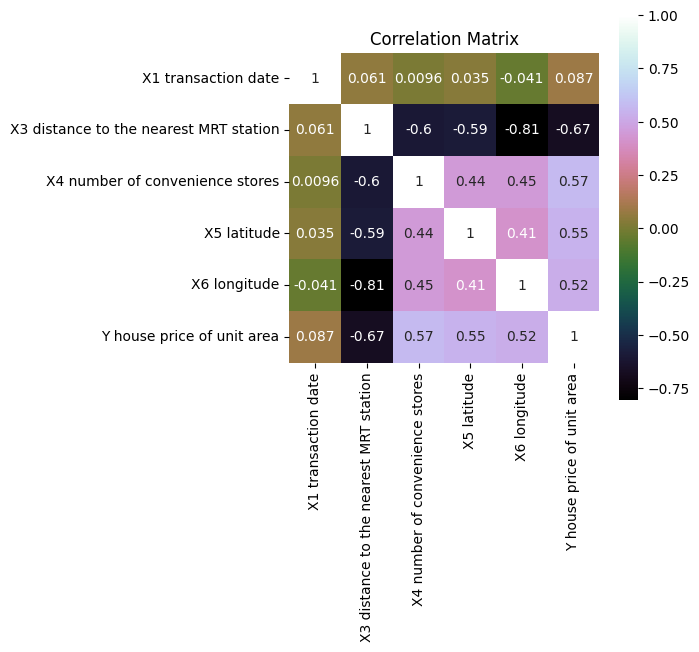

In [18]:
correlation = housing.corr()
plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

#### Вывод сортированных значений коэффициентов корреляции по Y

In [19]:
correlation[housing.columns[-1]].sort_values(ascending=False, key=lambda x: abs(x))

Y house price of unit area                1.000000
X3 distance to the nearest MRT station   -0.673613
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
Name: Y house price of unit area, dtype: float64

Согласно интерпретации коэффициента корреляции по шкале Чеддока:
* X1 близко к 0, что означает отсутствие линейной корреляции;
* X3 - средняя отрицательная корреляция;
* X4-X6 - средняя положительная корреляция.

#### Построение диаграмм рассеиваний для значений X3-X6

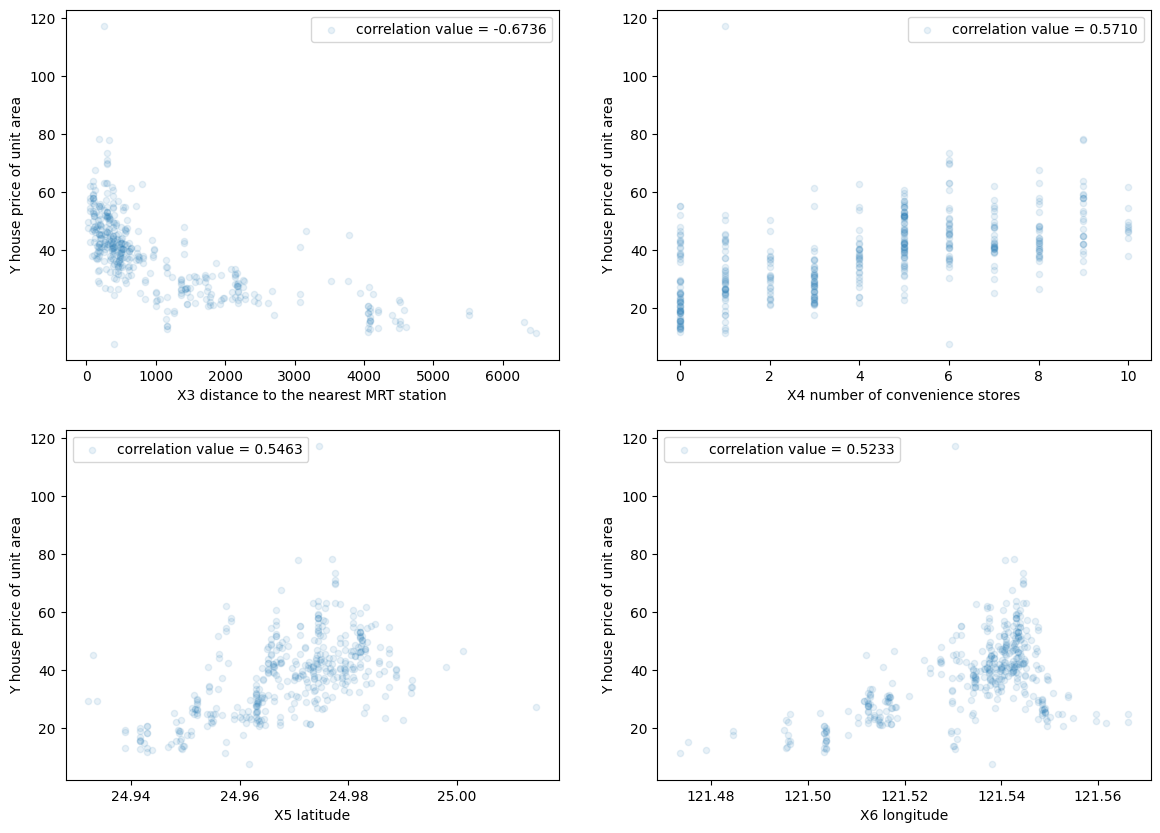

In [20]:
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
name_y = housing.columns[-1]
for name_x, ax in zip(housing.columns[1:-1], axes.ravel()):
    housing.plot(ax=ax, kind='scatter', x = name_x, y = name_y, label=f'correlation value = {correlation[name_y][name_x]:.4f}', alpha=0.1)

### (e) Комбинации атрибутов

Выполним проверку коэффициентов корреляции попарных отношений параметров с Y.

In [21]:
corr_y = pd.DataFrame(columns=['i', 'j', 'i/j', 'j/i'])
y = housing[housing.columns[-1]]
for name in housing.columns[:5]:
    print(name)
for i in range(4):
    for j in range(i + 1, 5):
        name_xi = housing.columns[i]
        name_xj = housing.columns[j]
        r1 = housing[name_xi] / housing[name_xj]
        r2 = housing[name_xj] / housing[name_xi]
        df = pd.DataFrame(data={'r1': r1, 'r2': r2, 'y': y})
        corr = df.corr()
        corr_y.loc[len(corr_y.index)] = [name_xi[:2], name_xj[:2], corr['y']['r1'], corr['y']['r2']]
# Сортировка по максимальному по модулю для xi и xj
corr_y.sort_values(by='i', ascending=False, key=lambda x: abs(corr_y.iloc[:, 2:]).max(axis=1))

X1 transaction date
X3 distance to the nearest MRT station
X4 number of convenience stores
X5 latitude
X6 longitude


,i,j,i/j,j/i
0,X1,X3,0.455805,-0.673631
5,X3,X5,-0.673608,0.455841
6,X3,X6,-0.673574,0.455754
1,X1,X4,-0.399810,0.570986
8,X4,X6,0.570980,-0.399756
7,X4,X5,0.570954,-0.399644
2,X1,X5,-0.506887,0.506759
4,X3,X4,-0.503675,0.431922
9,X5,X6,0.447113,-0.447274
3,X1,X6,-0.279823,0.279757


По имеющимся результатам можно сделать вывод, что наибольший (по модулю) коэффициент корреляции имеют параметры ```расстояние до ближайшей станции метро``` / ```широта|долгота``` (\\( \approx \\) 0.67), однако переменная X3 сама по себе имеет большой коэффициент корреляции с Y (\\( \approx \\) 0.67). Было принято решение не добавлять дополнительных параметров в виде их отношений.

### (f) Отбор существенных (информативных) признаков

In [22]:
housing_X = housing.iloc[:, :5]
housing_Y = housing['Y house price of unit area']
bestfeatures = SelectKBest(k=5)
fit = bestfeatures.fit(housing_X, housing_Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(housing_X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores

,0,0
0,X1 transaction date,0.993150
1,X3 distance to the nearest MRT station,4.792860
2,X4 number of convenience stores,2.010420
3,X5 latitude,2.353937
4,X6 longitude,1.903160


Исходя из полученных значений, наиболее информативными признаками являются X3-X6. Уберем неинформативный столбец X1.

### (g) Стандартизация

In [23]:
scaler = StandardScaler().fit(housing_X)
first_housing_X = pd.DataFrame(scaler.fit_transform(housing_X), columns=housing_X.columns)
second_housing_X = first_housing_X.drop(housing_X.columns[0], axis=1) # Удалили X1

In [24]:
first_housing_X

,X1 transaction date,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,-0.823683,-0.792495,2.007407,1.125430,0.448762
1,-0.823683,-0.616612,1.667503,0.912444,0.401139
2,1.541151,-0.414015,0.307885,1.486860,0.688183
3,1.246435,-0.414015,0.307885,1.486860,0.688183
4,-1.121951,-0.549997,0.307885,0.834188,0.592937
...,...,...,...,...,...
409,-0.528967,2.378365,-1.391638,-2.216993,-1.927835
410,-1.711384,-0.788071,1.667503,0.427579,0.635341
411,0.358734,-0.549678,0.987694,0.822893,0.423972
412,-0.528967,-0.776684,0.307885,-0.184755,0.476814


In [25]:
second_housing_X

,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,-0.792495,2.007407,1.125430,0.448762
1,-0.616612,1.667503,0.912444,0.401139
2,-0.414015,0.307885,1.486860,0.688183
3,-0.414015,0.307885,1.486860,0.688183
4,-0.549997,0.307885,0.834188,0.592937
...,...,...,...,...
409,2.378365,-1.391638,-2.216993,-1.927835
410,-0.788071,1.667503,0.427579,0.635341
411,-0.549678,0.987694,0.822893,0.423972
412,-0.776684,0.307885,-0.184755,0.476814


Сохраним модель

In [26]:
def save_housing(save_name, housing):
    save_data = pd.concat([housing, housing[housing.columns[-1]]], axis=1)
    save_path = os.path.join(HOUSING_PATH, save_name)
    dump(housing, open(save_path, 'wb'))

In [27]:
save_housing('first_housing.sav', first_housing_X)
save_housing('second_housing.sav', second_housing_X)

Сохраним полученные наборы данных

In [28]:
def save_csv(save_name, hhousing):
    save_data_csv = pd.concat([hhousing, housing[housing.columns[-1]]], axis=1)
    save_path = os.path.join(HOUSING_PATH, save_name)
    save_data_csv.to_csv(save_path, index=False, encoding='utf-8', sep=',')
    hhousing

In [29]:
save_csv('first_housing.csv', first_housing_X)
save_csv('second_housing.csv', second_housing_X)

## Выделим обучающую и тестовую выборки

Выделим тестовую выборку как 20% от исходной, остальные 80% составят обучающую вуборку.
Исползуем заданное начальное значение для параметра ```random_state```, чтобы получать одни и те же обучающию и тестовую выборки при повторном запуске.

In [30]:
validation_size = 0.2
seed = 7
X_train_f, X_test_f, Y_train_f, Y_test_f = train_test_split(first_housing_X, housing_Y, test_size=validation_size, random_state=seed)
X_train_s, X_test_s, Y_train_s, Y_test_s = train_test_split(second_housing_X, housing_Y, test_size=validation_size, random_state=seed)
# Дополнительный набор с X3 (наибольший по модулю коэффициент корреляции)
housing_X3 = pd.DataFrame(first_housing_X['X3 distance to the nearest MRT station'])
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(housing_X3, housing_Y, test_size=validation_size, random_state=seed)

## Сравним линейную и полиномиальную регрессионные модели

### Определение переменной и функции для получения информации о моделях с целью их сравнения.

In [31]:
model_quality = pd.DataFrame(columns=['RMSE', 'R2_score'])

In [32]:
def evaluate_model(name, X, Y, rows=1, cols=1, XY_test=None, k=None, is_show_info=True):
    X_pred = X
    # Если требуется построить полином k-степени
    if k is not None:
        polynomial_features = PolynomialFeatures(degree=k)
        X_pred = polynomial_features.fit_transform(X)
    if XY_test is not None:
        X_test = XY_test[0]
        Y_test = XY_test[1]
        if k is not None:
            polynomial_features = PolynomialFeatures(degree=k)
            X_test = polynomial_features.fit_transform(X_test)
    else:
        X_test = X_pred
        Y_test = Y
    # Построение модели
    model = ElasticNet(alpha=0.5)
    model.fit(X_pred, Y)
    Y_pred = model.predict(X_test)
    # Расчёт критериев качества
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    model_quality.loc[name] = [rmse, r2]
    # Печать информании
    if is_show_info:
        print(f'RMSE for {name}: {rmse}')
        print(f'R2_score for {name}: {r2}')
        # Вывод графиков
        f = plt.figure(figsize=(6 * cols, 4 * rows))
        for i, name_x in enumerate(X):
            ax = f.add_subplot(rows, cols, i + 1)
            if XY_test is not None:
                x = XY_test[0]
            else:
                x = X[name_x]
            sort_xy = pd.DataFrame({'X': x, 'Y': Y_pred})
            sort_xy.sort_values(by='X', inplace=True)
            ax.plot(x, Y_test, 'o', alpha=0.3)
            ax.plot(x, Y_pred, 'o', alpha=0.5)
            ax.plot(sort_xy.X, sort_xy.Y, "r-")
            ax.set_xlabel(name_x)
            ax.set_ylabel('Y_pred for ' + name)

### Применение линейной регрессии (эластичная сеть) для существенных признаков

RMSE for Elastic Net (second): 9.877639032552972
R2_score for Elastic Net (second): 0.5173876384902331


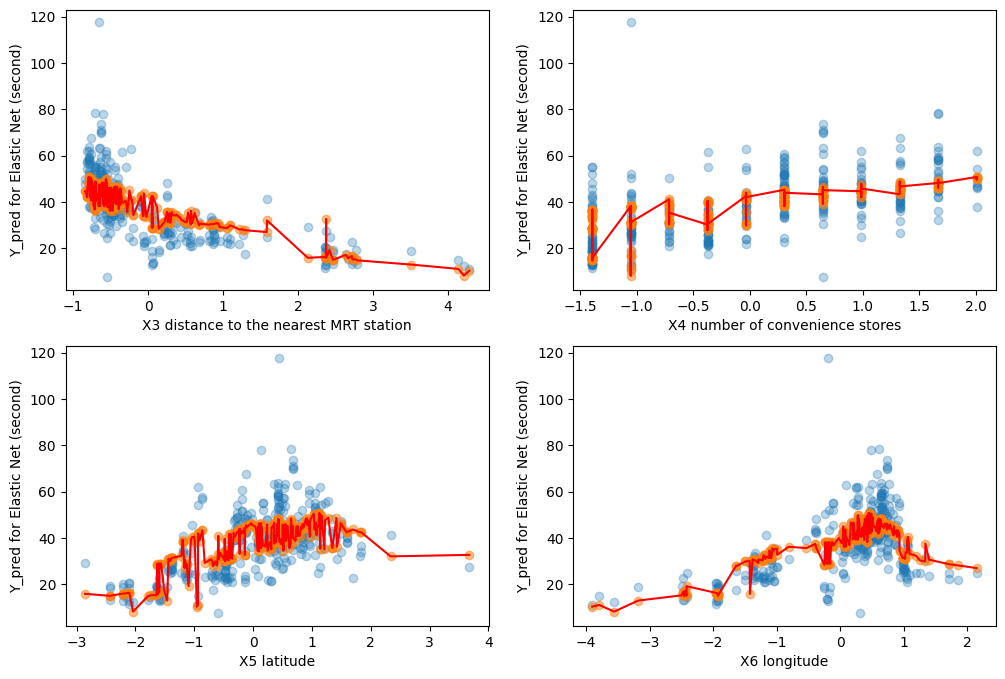

In [33]:
evaluate_model('Elastic Net (second)', X_train_s, Y_train_s, rows=2, cols=2)

### Применение линейной регрессии (эластичная сеть) для исходных признаков

RMSE for Elastic Net (first): 9.774855001937695
R2_score for Elastic Net (first): 0.5273792480860923


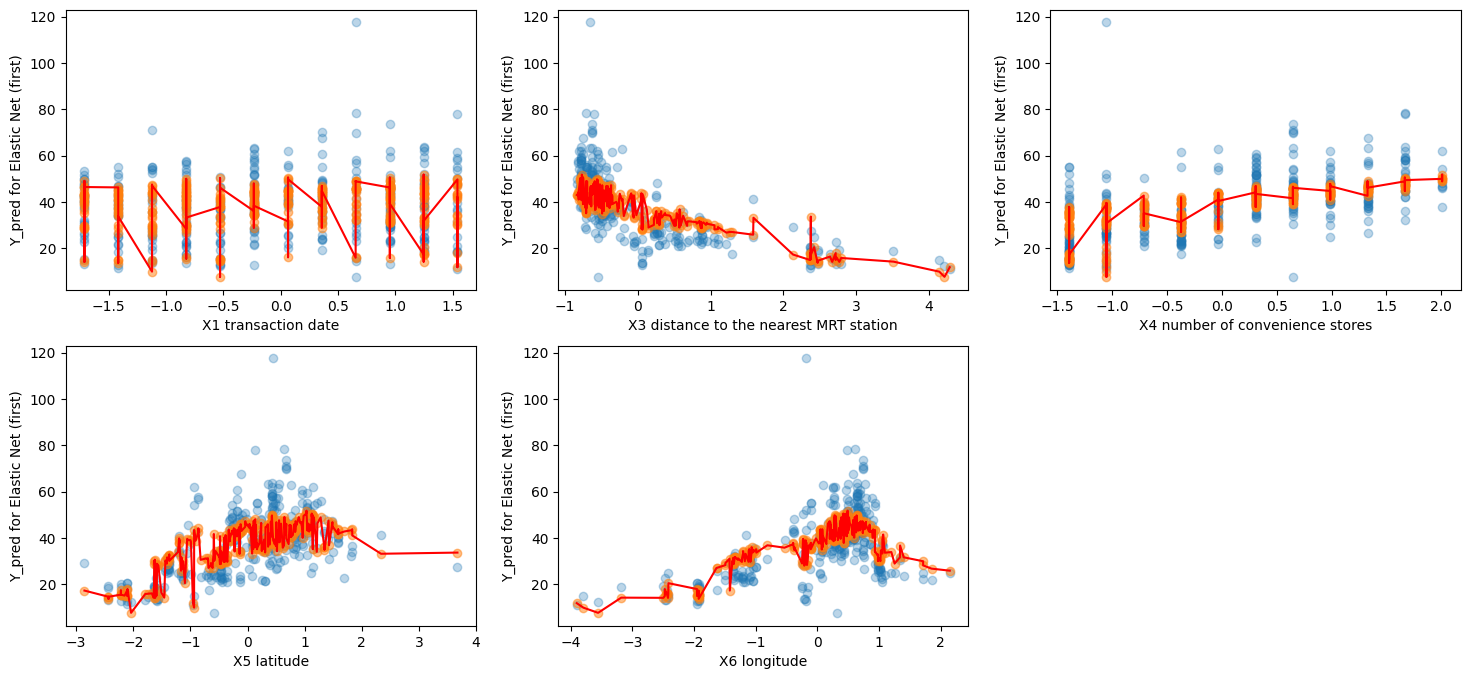

In [34]:
evaluate_model('Elastic Net (first)', X_train_f, Y_train_f, rows=2, cols=3)

### Применение линейной регрессии (эластичная сеть) для X3

RMSE for Elastic Net (X3): 10.69712133527611
R2_score for Elastic Net (X3): 0.43398755145291446


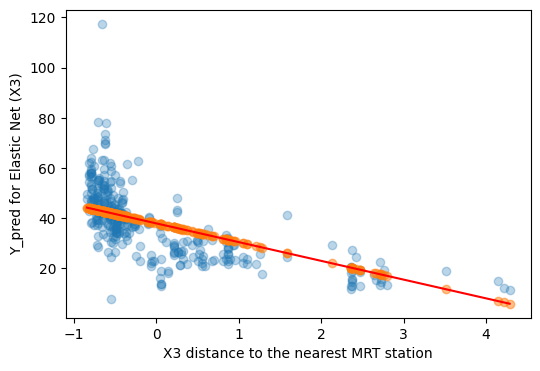

In [35]:
evaluate_model('Elastic Net (X3)', X_train_3, Y_train_3, rows=1, cols=1)

### Применение полиномиальной регрессии (квадратичной) для существенных признаков

RMSE for Polynomial (second): 9.380122900835847
R2_score for Polynomial (second): 0.5647796475345223


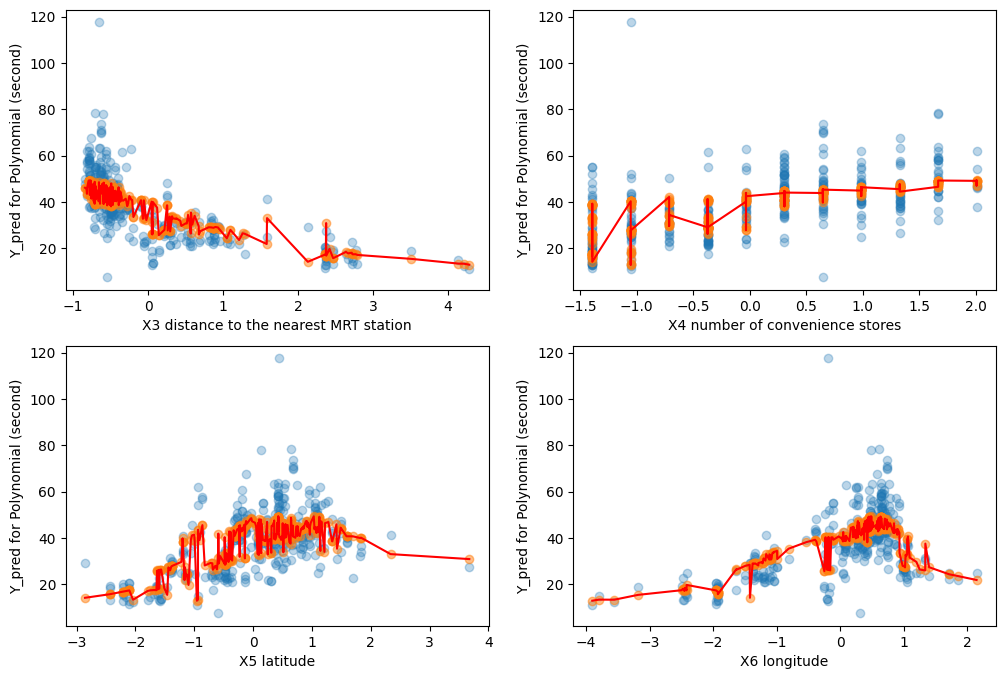

In [36]:
evaluate_model('Polynomial (second)', X_train_s, Y_train_s, rows=2, cols=2, k=2)

### Применение полиномиальной регрессии (квадратичной) для исходных признаков

RMSE for Polynomial (first): 9.254839500946229
R2_score for Polynomial (first): 0.5763278447093533


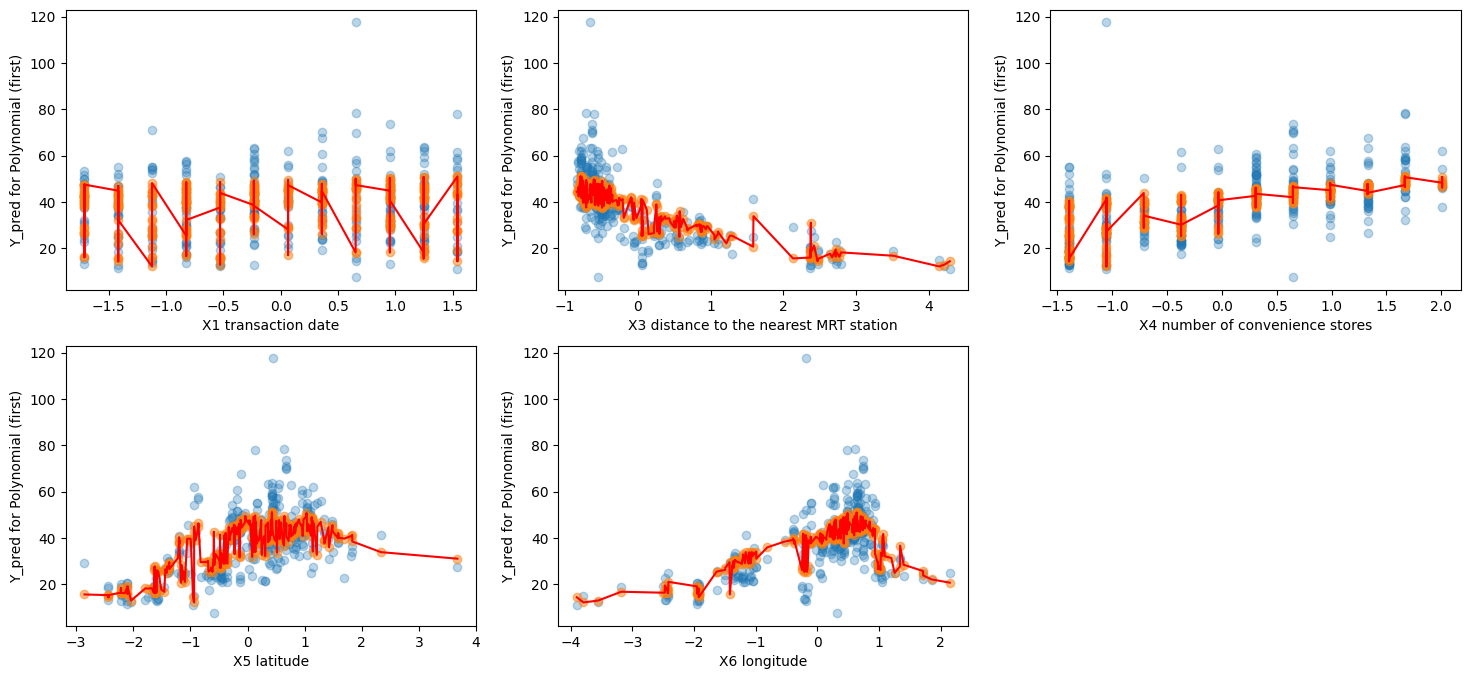

In [37]:
evaluate_model('Polynomial (first)', X_train_f, Y_train_f, rows=2, cols=3, k=2)

### Применение полиномиальной регрессии (квадратичной) для X3

RMSE for Polynomial (X3): 10.563277117176149
R2_score for Polynomial (X3): 0.44806302949413024


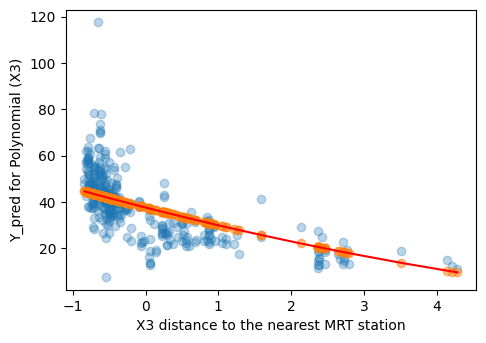

In [38]:
evaluate_model('Polynomial (X3)', X_train_3, Y_train_3, rows=2, cols=3, k=2)

### Сравнение моделей

In [39]:
model_quality.T

,Elastic Net (second),Elastic Net (first),Elastic Net (X3),Polynomial (second),Polynomial (first),Polynomial (X3)
RMSE,9.877639,9.774855,10.697121,9.380123,9.254840,10.563277
R2_score,0.517388,0.527379,0.433988,0.564780,0.576328,0.448063


Исходя из полученных резултатов можно сделать вывод, что лучше всего подходит полиномиальная модель с исходным набором данных ```Polynomial (first)```.

Полиномиальная модель (```Polynomial```) имеет немного лучшие значение среднеквадратичной ошибки ```RMSE``` для обеих выборок, а также для отдельно выделенного параметра X3 по сравнению с эластичной сетью (```Elastic Net```). Тоже самое наблюдается с коэффициентом детерминации (```R2_score```): оценки для полиномиальной модели выше, чем для эластичной сети. 

Таким образом, дальнейший Grid-поиск будет проводится с использованием модели ```Polynomial (first)```.

## Grid-поиск для Polynomial (first) на обучающих данных

In [40]:
model_quality.drop(model_quality.index, inplace=True)
x = np.arange(2, 4)
for k in x:
    evaluate_model(f'Polynomial k={k}', X_train_f, Y_train_f, k=k, is_show_info=False)
model_quality.T

,Polynomial k=2,Polynomial k=3
RMSE,9.254840,9.133844
R2_score,0.576328,0.587333


На обучающей выборке лучшее значение дает полином с 3 степенью.

## Grid-поиск для Polynomial (first) на тестовых данных

In [41]:
model_quality.drop(model_quality.index, inplace=True)
x = np.arange(2, 4)
for k in x:
    evaluate_model(f'Polynomial k={k}', X_train_f, Y_train_f, k=k, is_show_info=False, XY_test=(X_test_f, Y_test_f))
model_quality.T

,Polynomial k=2,Polynomial k=3
RMSE,7.328406,7.187660
R2_score,0.532948,0.550715


На тестовой выборке лучшее значение также дает полнином с 3 степенью.

# Выводы:

В ходе выполнения работы был выполнен предиктивный анализ данных на основе регрессионных моделей в соответствии с заданной последовательностью этапов для указанного по варианту набора цен на недвижимость. 

В начале работы было предложено рассмотреть 6 переменных (X1-X6).

В результате процесса очистки данных, было решено удалить столбец X2, так как замена значение не дало положительных результатов. Коэффициент корреляции с Y при: 
- удалении записей: -0.195;
- замене на медиану: -0.144;
- замене на среднее: -0.144
- замене на 0: -0.098. 

Удаление записей уменьшило бы размер выборки в 2 раза. Также по сравнение с X3-X6, параметр имел меньший размер коэффициента корреляции.

Переменную X1 было решено убрать из-за отсутствии линейной корреляции с Y (0.087).

В результате, были рассмотрены три набора: first (X1, X3-X6), second (X3-X6) и X3 (X3).

Исходя из результатов сравнения, лучшей оказалась полиномиальная модель ```Polynomial (first)```. Для нее, по результатам Grid-поиска, был определен гиперпараметр. На обучающей и тестовой выборках модель ```Polynomial (first)``` 3 степени показала лучший результат.

---

### Проверка корректности работы функции evaluate_model
### (вне лабораторной работы, пример из лекции)

RMSE for Elastic Net: 29.18537301238901
R2_score for Elastic Net: 0.5008854091856869
RMSE for Polynomial: 11.768823235182804
R2_score for Polynomial: 0.9188411566208826


,Elastic Net,Polynomial
RMSE,29.185373,11.768823
R2_score,0.500885,0.918841


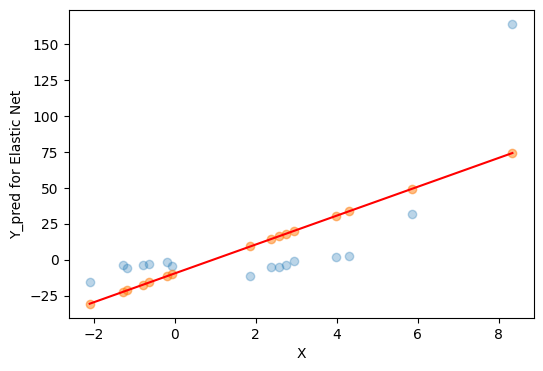

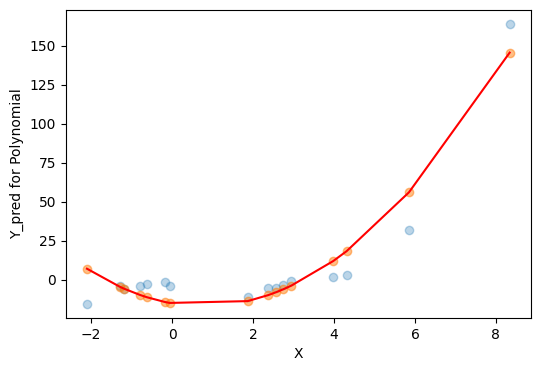

In [42]:
validation_size = 0.2
seed = 7
X = 2 - 3 * np.random.normal(0, 1, 20)
Y = X - 2 * (X ** 2) + 0.5 * (X ** 3) + np.exp(-X) + np.random.normal(-3, 3, 20)
X = pd.DataFrame(X[:, np.newaxis], columns=['X'])
Y = pd.DataFrame(Y[:, np.newaxis], columns=['Y'])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)
model_quality.drop(model_quality.index, inplace=True)
evaluate_model('Elastic Net', X_train, Y_train)
evaluate_model('Polynomial', X_train, Y_train, k=2)
model_quality.T